In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore") 
pd.set_option("display.max_columns", None) # 设置 Pandas 显示选项，显示所有列
cut_type = 'peryear' # 定义切分类型为按年
train_type = 'scilearn' # 定义训练类型为 scikit-learn
data_type = 'all' # 定义数据类型为所有数据

df_asset_details = pd.read_csv("/Users/wujoy/Desktop/7409project/solution/input/g-research-crypto-forecasting/asset_details.csv").sort_values("Asset_ID")
df = pd.read_csv("/Users/wujoy/Desktop/7409project/solution/input/g-research-crypto-forecasting/train.csv")
df_sup = pd.read_csv("/Users/wujoy/Desktop/7409project/solution/input/g-research-crypto-forecasting/supplemental_train.csv")
df_sup = df_sup[df_sup.timestamp>df.timestamp.max()]
df = pd.concat([df,df_sup]).reset_index(drop=True)

df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.replace([np.inf, -np.inf], np.nan)  #替换无穷大值为NaN
df = df.sort_values(by='datetime').reset_index(drop=True)  #按时间排序并重置索引
df = df[~df.Target.isna()].reset_index(drop=True)  #处理Target缺失值

time_windows = [15, 30, 60, 90, 150, 600, 1500]
for window in time_windows:
    df[f'Close_now_{window}'] = df.groupby('Asset_ID')['Close'].shift(window) / df['Close']  #计算涨幅
    df[f'Volume_now_{window}'] = df.groupby('Asset_ID')['Volume'].shift(window) / df['Volume']  #计算量比

####计算加权平均价格
def get_weighted_asset_feature(df, col):
    df['w'] = df['Asset_ID'].map(df_asset_details.set_index(keys='Asset_ID')['Weight'])
    weight_sum = df_asset_details.Weight.sum()

    df['W_'+col] = df.w * df[col]
    time_group = df.groupby('datetime')

    m = time_group['W_'+col].sum() / time_group['w'].sum()

    df.set_index(keys=['datetime'], inplace=True)
    df['W_'+col] = m
    df.reset_index(inplace=True)
    return df

df = get_weighted_asset_feature(df, 'Close_now_15')

####划分训练集与测试集
split_date = "2021-06-13 00:00:00" # 按时间8：2划分
df_train = df[df["datetime"] < split_date].reset_index(drop=True)
df_test = df[df["datetime"] >= split_date].reset_index(drop=True)

import gc
del df
gc.collect()

0

In [18]:
df_train = df_train[~df_train.Target.isna()].reset_index(drop=True)
df_test = df_test[~df_test.Target.isna()].reset_index(drop=True)

# features = ['Count', 'Open', 'High', 'Low', 'Close','Volume', 'VWAP', 'm', 'Close_now_5', 'Close_now_15',
#     'Close_now_60', 'Close_now_150', 'Close_now_600']

features = df_test.columns.tolist()
remove_cols = ['datetime', 'timestamp', 'w', 'Target', 'Close'] 
features = [f for f in features if f not in remove_cols]
target = "Close"


In [19]:
from datetime import datetime

print('train data begin date:',datetime.fromtimestamp(df_train.timestamp.min()))
print('train data begin date:',datetime.fromtimestamp(df_train.timestamp.max()))
print('test data begin date:',datetime.fromtimestamp(df_test.timestamp.min()))
print('test data begin date:',datetime.fromtimestamp(df_test.timestamp.max()))

train data begin date: 2018-01-02 09:01:00
train data begin date: 2021-06-13 07:59:00
test data begin date: 2021-06-13 08:00:00
test data begin date: 2022-01-24 07:44:00


In [20]:
from sklearn.model_selection import KFold,GroupKFold

enumeratelist = []
for month_tmp in ['2018-01-01','2018-11-12','2019-09-23','2020-08-03']:
    trn_val_ind = df_train[df_train.datetime>=month_tmp].index.tolist()
    trn_ind = trn_val_ind[:int(len(trn_val_ind)*0.9)]
    val_ind = trn_val_ind[int(len(trn_val_ind)*0.9):]
    print(df_train['datetime'].iloc[trn_ind].min(),df_train['datetime'].iloc[val_ind].max())
    enumeratelist.append([trn_ind,val_ind])

2018-01-02 01:01:00 2021-06-12 23:59:00
2018-11-12 00:00:00 2021-06-12 23:59:00
2019-09-23 00:00:00 2021-06-12 23:59:00
2020-08-03 00:00:00 2021-06-12 23:59:00


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import os

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(df_train[features])
X_test_scaled = scaler_X.transform(df_test[features])
y_train_scaled = scaler_y.fit_transform(df_train[target].values.reshape(-1, 1)).flatten()

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'max_depth': -1,
    'min_data_in_leaf': 500,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  
    'reg_lambda': 0.5,
    'n_jobs': -1,
    'random_state': 42,
    'verbosity': -1,
    'n_estimators': 1000
}

os.makedirs('./catM', exist_ok=True)
modellist = []
test_predictions = np.zeros((df_test.shape[0], len(enumeratelist)))
modelpath = './catM'

for fold, (trn_ind, val_ind) in enumerate(enumeratelist):
    print(f'Training fold {fold + 1}')

    X_trn = X_train_scaled[trn_ind]
    y_trn = y_train_scaled[trn_ind]
    X_val = X_train_scaled[val_ind]
    y_val = scaler_y.transform(df_train[target].iloc[val_ind].values.reshape(-1, 1)).flatten()

    model = LGBMRegressor(**params)

    model.fit(
        X_trn, y_trn,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            early_stopping(stopping_rounds=100), 
            log_evaluation(10)
        ]
    )
    
    saving_path_name = f"{modelpath}/lgb_fold{fold}.txt"
    model.booster_.save_model(saving_path_name)
    modellist.append(model)

    fold_pred = model.predict(X_test_scaled)
    test_predictions[:, fold] = scaler_y.inverse_transform(fold_pred.reshape(-1, 1)).flatten()

final_predictions = test_predictions.mean(axis=1)
test_rmse = mean_squared_error(df_test[target], final_predictions, squared=False)
print(f"Test RMSE (denormalized): {test_rmse:.4f}")

Training fold 1
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 2.2764
[20]	valid_0's rmse: 2.10534
[30]	valid_0's rmse: 1.94991
[40]	valid_0's rmse: 1.80789
[50]	valid_0's rmse: 1.68064
[60]	valid_0's rmse: 1.56541
[70]	valid_0's rmse: 1.46217
[80]	valid_0's rmse: 1.36705
[90]	valid_0's rmse: 1.28332
[100]	valid_0's rmse: 1.2068
[110]	valid_0's rmse: 1.1379
[120]	valid_0's rmse: 1.07557
[130]	valid_0's rmse: 1.0195
[140]	valid_0's rmse: 0.969453
[150]	valid_0's rmse: 0.924138
[160]	valid_0's rmse: 0.882913
[170]	valid_0's rmse: 0.84611
[180]	valid_0's rmse: 0.813015
[190]	valid_0's rmse: 0.782929
[200]	valid_0's rmse: 0.756374
[210]	valid_0's rmse: 0.732342
[220]	valid_0's rmse: 0.71068
[230]	valid_0's rmse: 0.690719
[240]	valid_0's rmse: 0.672689
[250]	valid_0's rmse: 0.657011
[260]	valid_0's rmse: 0.64247
[270]	valid_0's rmse: 0.629476
[280]	valid_0's rmse: 0.617845
[290]	valid_0's rmse: 0.607101
[300]	valid_0's rmse: 0.597425
[310]	valid_0's rmse:

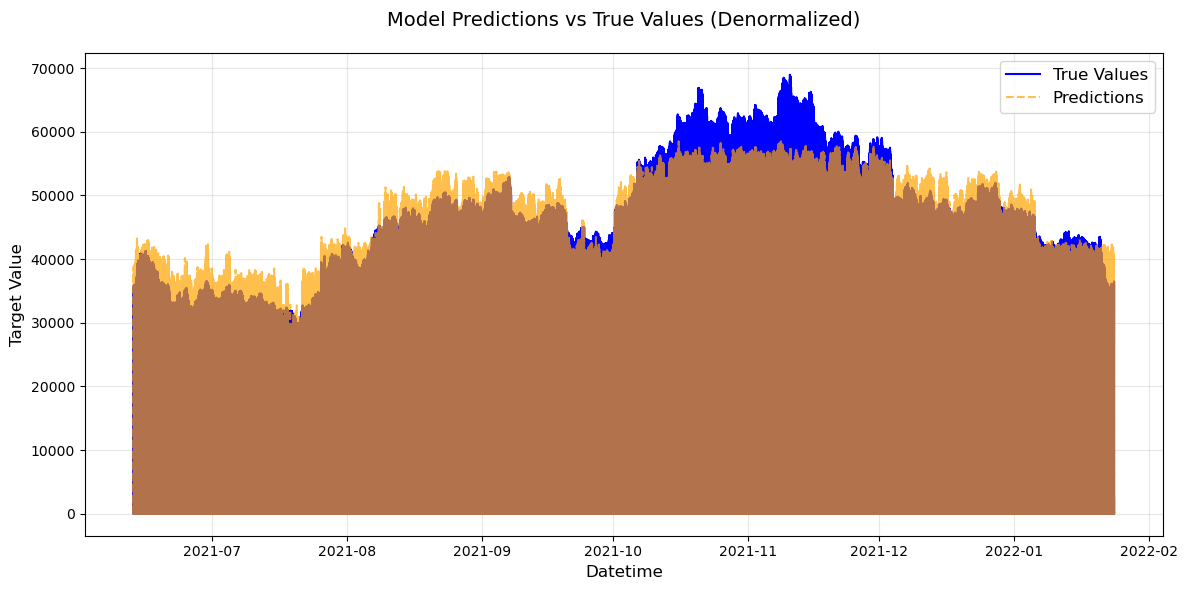

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_test['datetime'], df_test[target], label='True Values', color='blue', linewidth=1.5)
plt.plot(df_test['datetime'], final_predictions, label='Predictions', color='orange', alpha=0.7, linestyle='--')
plt.title('Model Predictions vs True Values (Denormalized)', fontsize=14, pad=20)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== Training CatBoost Fold 1/4 ===
0:	learn: 3529.3714226	test: 13256.6103226	best: 13256.6103226 (0)	total: 766ms	remaining: 19m 7s
50:	learn: 932.3184566	test: 5485.7136027	best: 5485.7136027 (50)	total: 21.2s	remaining: 10m 2s
100:	learn: 529.4163876	test: 3735.4476959	best: 3735.4476959 (100)	total: 43.5s	remaining: 10m 2s
150:	learn: 481.8395807	test: 3226.6377361	best: 3226.6377361 (150)	total: 1m 6s	remaining: 9m 54s
200:	learn: 469.5022366	test: 3062.5777485	best: 3062.5777485 (200)	total: 1m 31s	remaining: 9m 51s
250:	learn: 461.0740025	test: 2971.0861768	best: 2971.0861768 (250)	total: 1m 57s	remaining: 9m 42s
300:	learn: 454.0641685	test: 2911.3778222	best: 2911.3778222 (300)	total: 2m 22s	remaining: 9m 25s
350:	learn: 448.1873469	test: 2869.0317429	best: 2869.0317429 (350)	total: 2m 53s	remaining: 9m 28s
400:	learn: 443.3108711	test: 2836.1263570	best: 2836.1263570 (400)	total: 3m 27s	remaining: 9m 27s
450:	learn: 439.1590878	test: 2813.8388759	best: 2813.8388759 (450)	tot

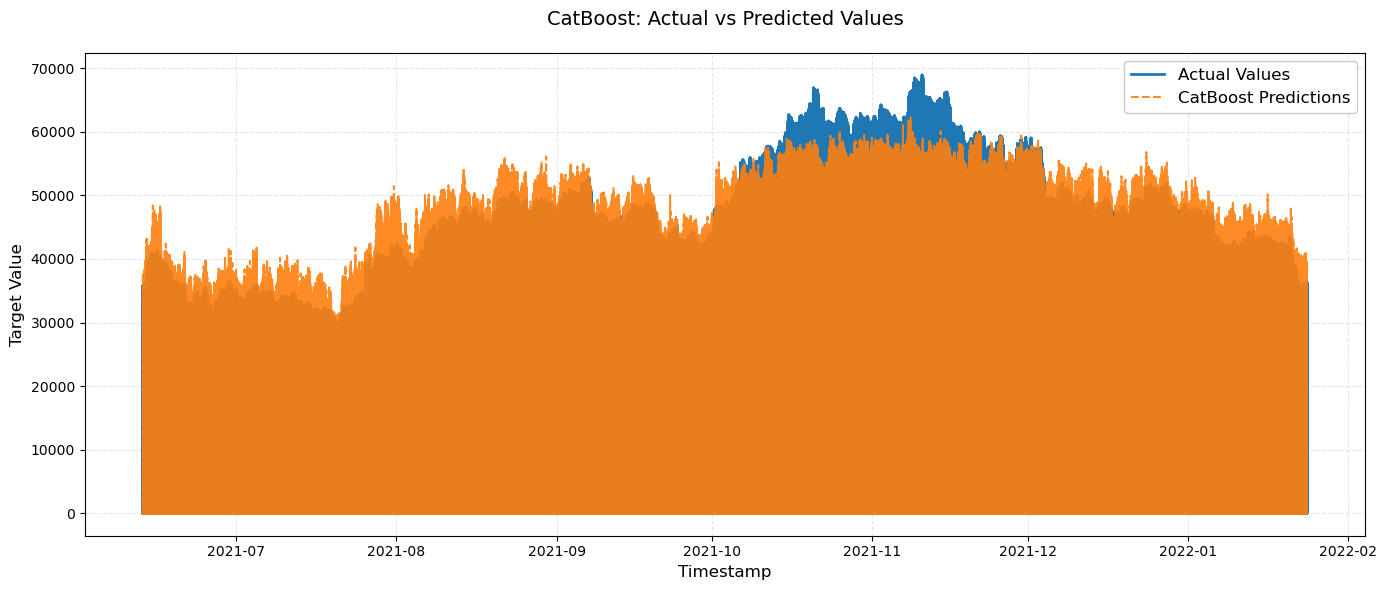

In [27]:
from catboost import CatBoostRegressor, Pool
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

catboost_models = []
test_predictions_catboost = np.zeros((df_test.shape[0], len(enumeratelist)))

for fold, (train_idx, val_idx) in enumerate(enumeratelist):
    print(f'\n=== Training CatBoost Fold {fold + 1}/{len(enumeratelist)} ===')
    
    train_pool = Pool(
        data=df_train[features].iloc[train_idx],
        label=df_train[target].iloc[train_idx]
    )
    val_pool = Pool(
        data=df_train[features].iloc[val_idx],
        label=df_train[target].iloc[val_idx]
    )
    test_pool = Pool(data=df_test[features])

    model = CatBoostRegressor(
        iterations=1500, 
        learning_rate=0.03, 
        depth=8, 
        l2_leaf_reg=3, 
        random_seed=42,
        loss_function='RMSE',
        eval_metric='RMSE',
        early_stopping_rounds=100, 
        task_type='CPU', 
        verbose=50  
    )
    
    # Train
    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True,
        plot=False
    )
    
    # Save model
    model_path = f"{modelpath}/catboost_fold{fold}.cbm"
    model.save_model(model_path, format="cbm")
    catboost_models.append(model)
    
    # Predict
    test_predictions_catboost[:, fold] = model.predict(test_pool)

final_predictions_catboost = test_predictions_catboost.mean(axis=1)
test_rmse_catboost = mean_squared_error(df_test[target], final_predictions_catboost, squared=False)
print(f"\nCatBoost Final Test RMSE: {test_rmse_catboost:.4f}")

# visualization
plt.figure(figsize=(14, 6))
plt.plot(df_test['datetime'], df_test[target], 
         label='Actual Values', color='#1f77b4', linewidth=2)
plt.plot(df_test['datetime'], final_predictions_catboost, 
         label='CatBoost Predictions', color='#ff7f0e', linestyle='--', alpha=0.9)
plt.title('CatBoost: Actual vs Predicted Values', fontsize=14, pad=20)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12, framealpha=1)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

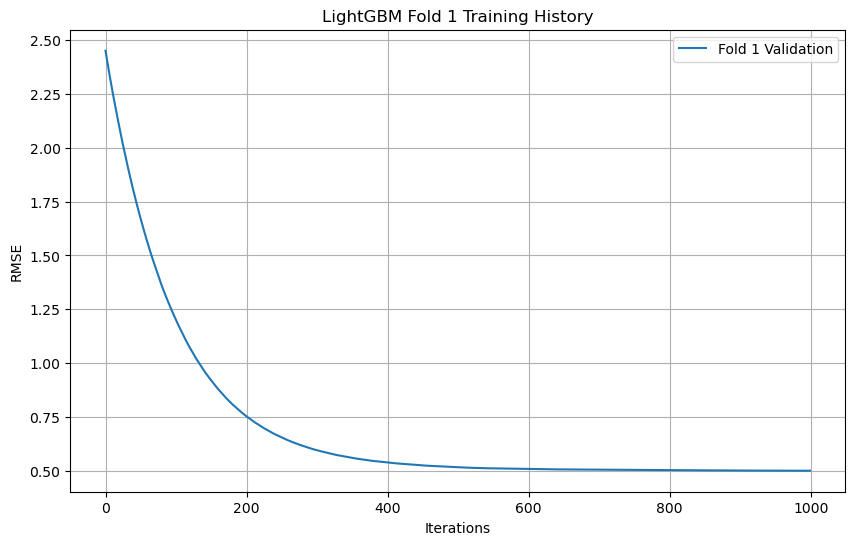

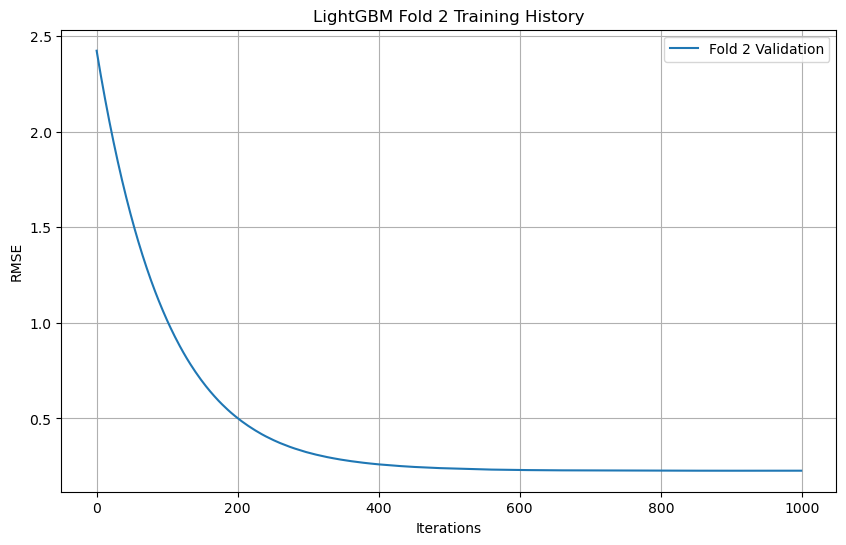

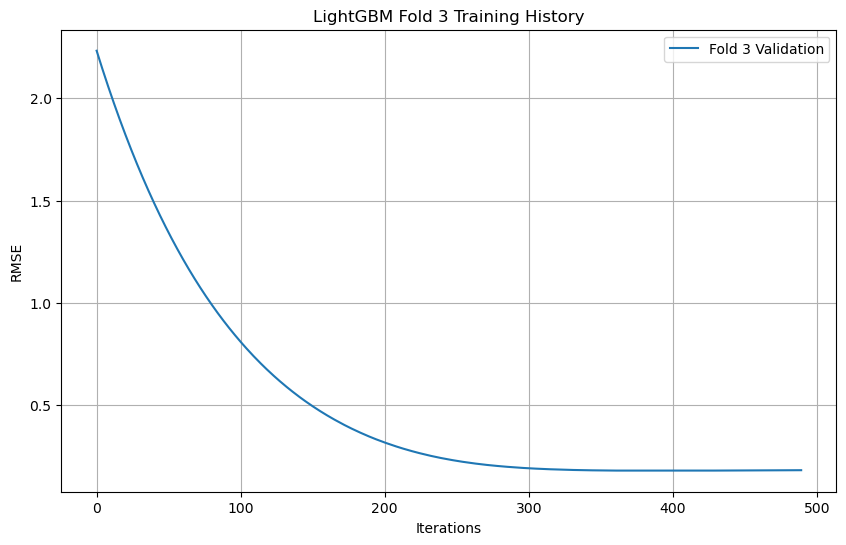

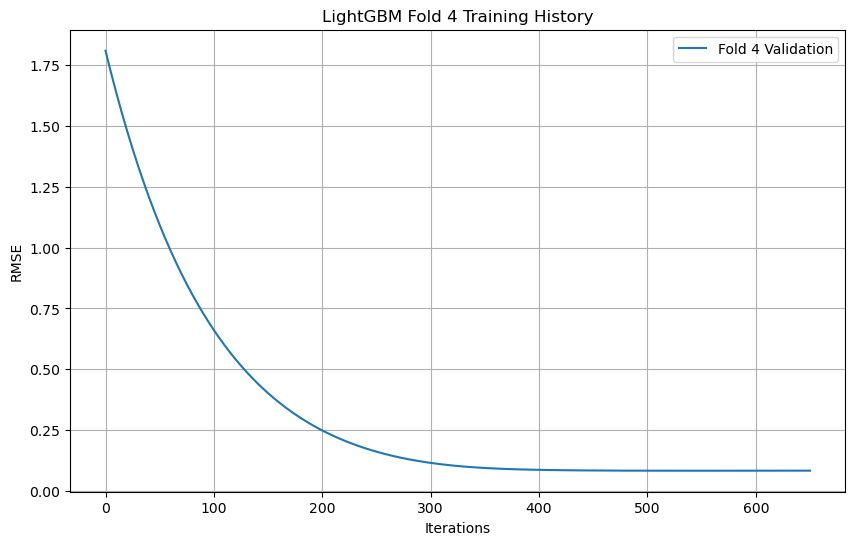

In [28]:
import matplotlib.pyplot as plt

for i, model in enumerate(modellist):
    results = model.evals_result_
    plt.figure(figsize=(10, 6))
    plt.plot(results['valid_0']['rmse'], label=f'Fold {i+1} Validation')
    plt.title(f'LightGBM Fold {i+1} Training History')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

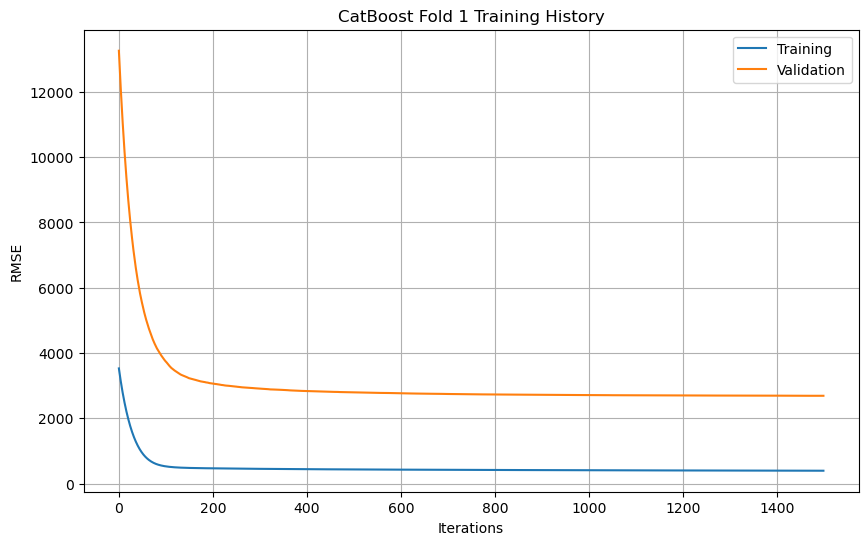

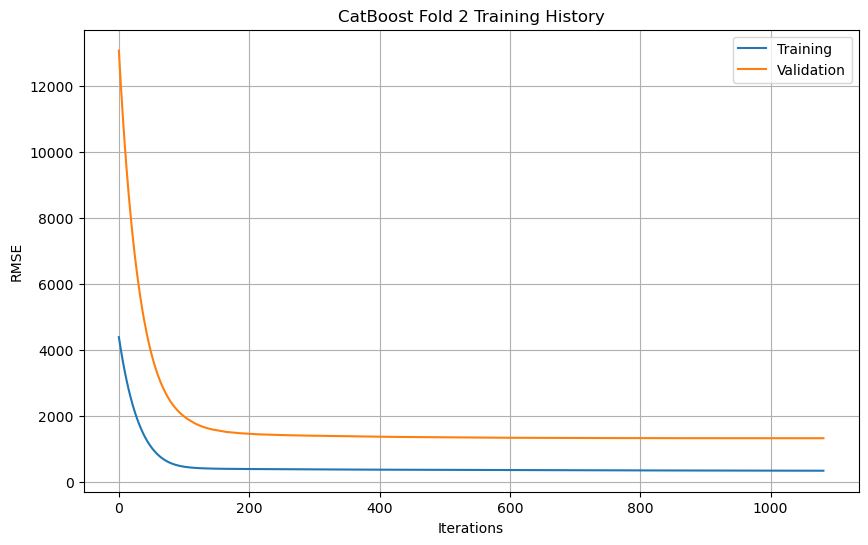

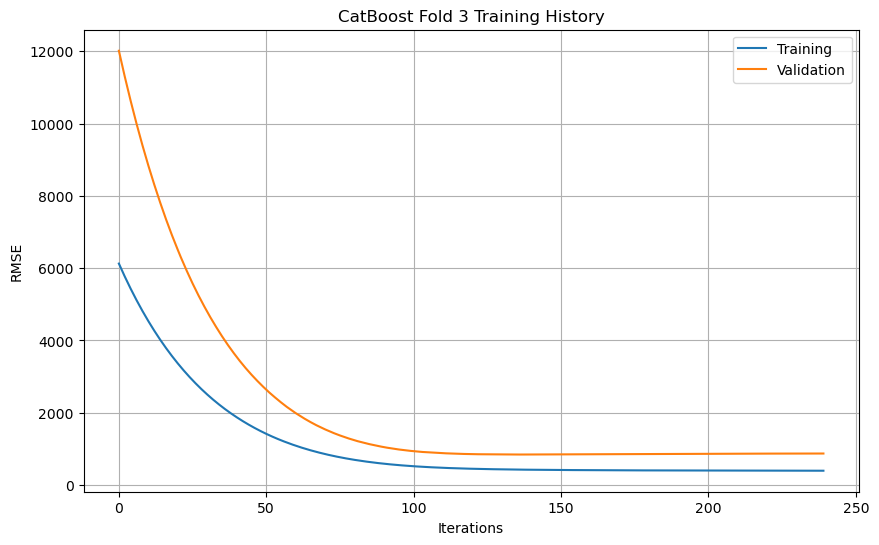

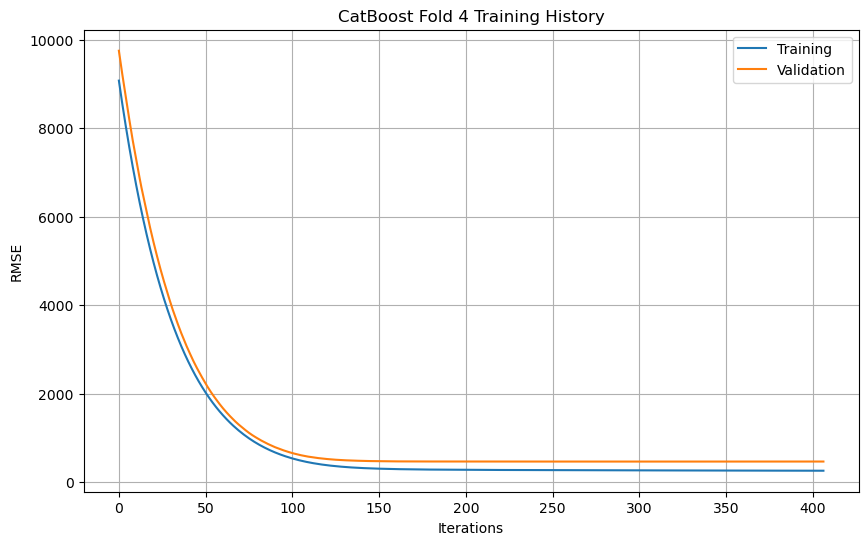

In [30]:
for i, model in enumerate(catboost_models):
    results = model.get_evals_result()
    plt.figure(figsize=(10, 6))
    plt.plot(results['learn']['RMSE'], label='Training')
    plt.plot(results['validation']['RMSE'], label='Validation')
    plt.title(f'CatBoost Fold {i+1} Training History')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()

<Figure size 1200x800 with 0 Axes>

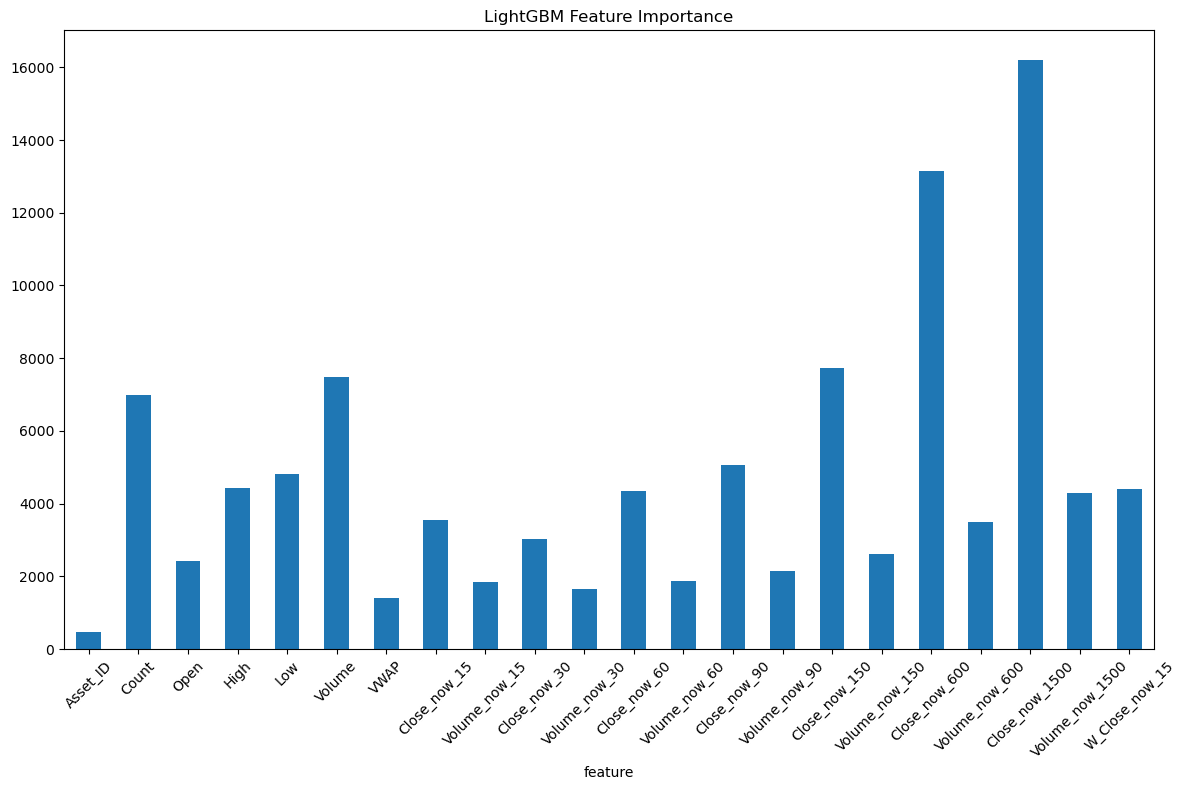

In [29]:
plt.figure(figsize=(12, 8))
for i, model in enumerate(modellist):
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_,
        'fold': i+1
    })
    if i == 0:
        ax = importance.plot.bar(x='feature', y='importance', legend=False, 
                               figsize=(12, 8), title='LightGBM Feature Importance')
    else:
        importance.plot.bar(x='feature', y='importance', legend=False, ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

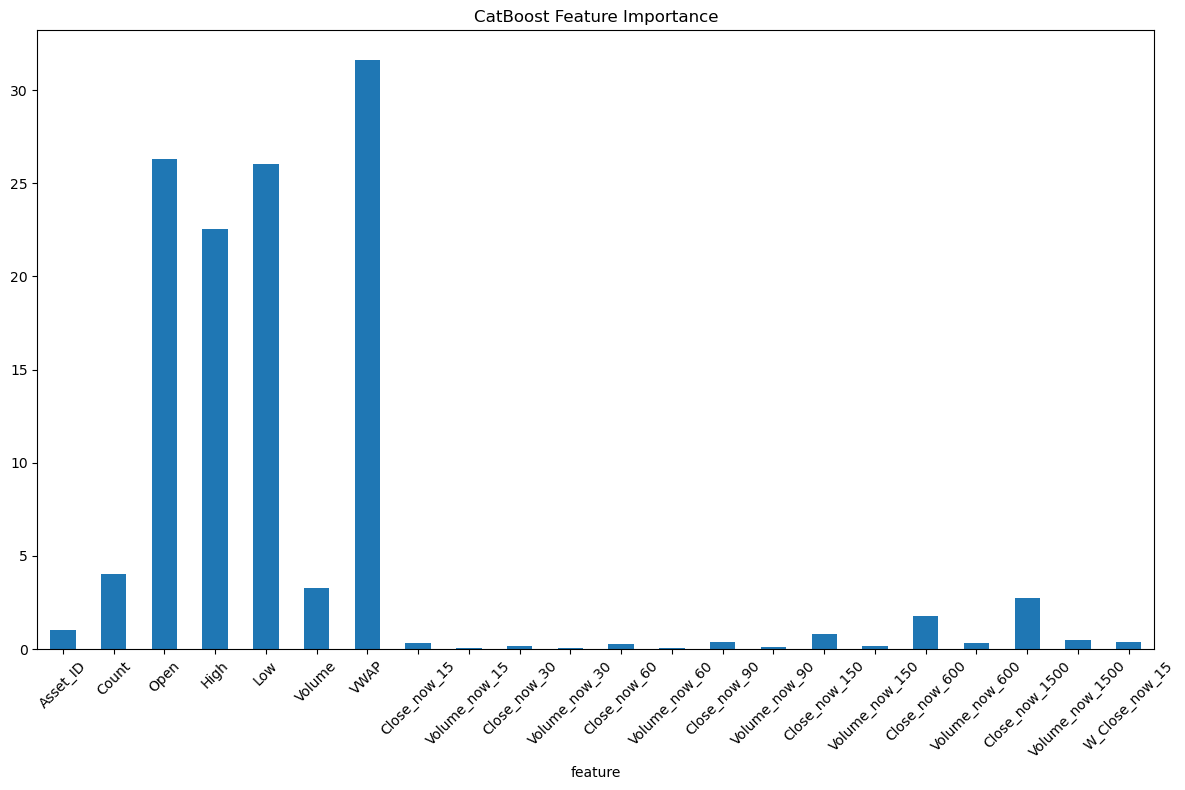

In [31]:
plt.figure(figsize=(12, 8))
for i, model in enumerate(catboost_models):
    importance = pd.DataFrame({
        'feature': features,
        'importance': model.get_feature_importance(),
        'fold': i+1
    })
    if i == 0:
        ax = importance.plot.bar(x='feature', y='importance', legend=False, 
                               figsize=(12, 8), title='CatBoost Feature Importance')
    else:
        importance.plot.bar(x='feature', y='importance', legend=False, ax=ax)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

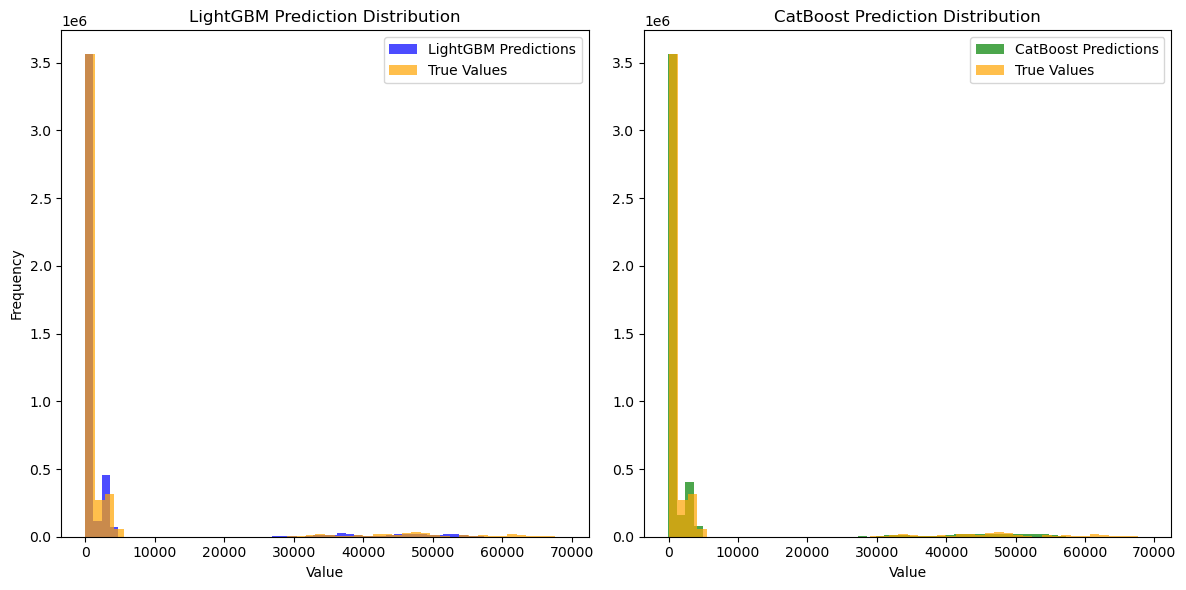

In [32]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(final_predictions, bins=50, alpha=0.7, color='blue', label='LightGBM Predictions')
plt.hist(df_test[target], bins=50, alpha=0.7, color='orange', label='True Values')
plt.title('LightGBM Prediction Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(final_predictions_catboost, bins=50, alpha=0.7, color='green', label='CatBoost Predictions')
plt.hist(df_test[target], bins=50, alpha=0.7, color='orange', label='True Values')
plt.title('CatBoost Prediction Distribution')
plt.xlabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

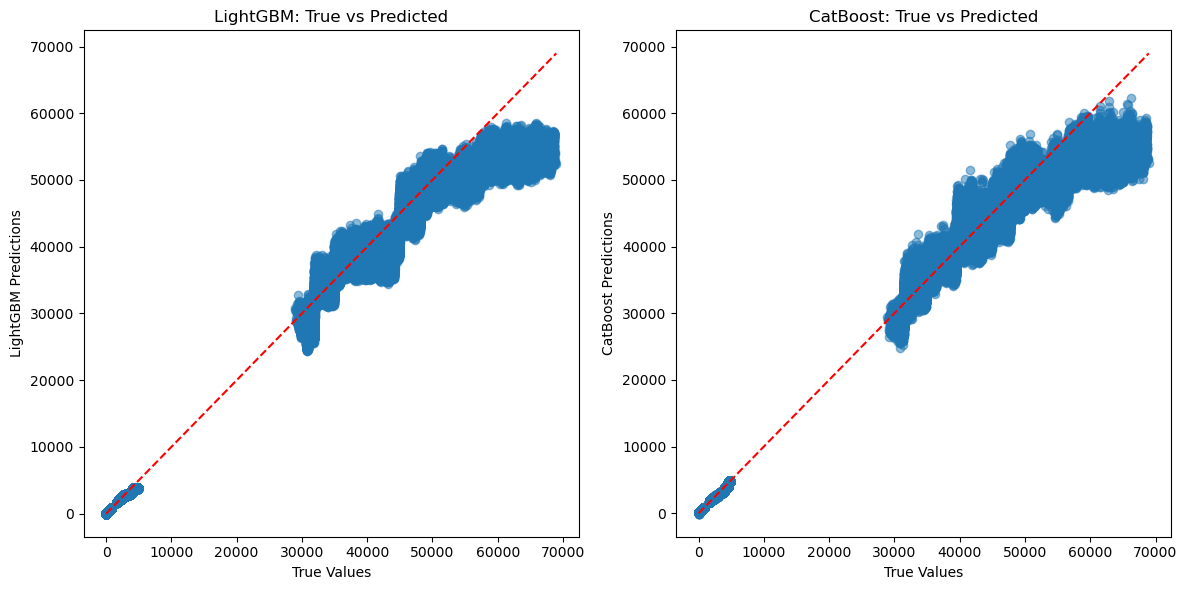

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(df_test[target], final_predictions, alpha=0.5)
plt.plot([min(df_test[target]), max(df_test[target])], 
         [min(df_test[target]), max(df_test[target])], 'r--')
plt.xlabel('True Values')
plt.ylabel('LightGBM Predictions')
plt.title('LightGBM: True vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(df_test[target], final_predictions_catboost, alpha=0.5)
plt.plot([min(df_test[target]), max(df_test[target])], 
         [min(df_test[target]), max(df_test[target])], 'r--')
plt.xlabel('True Values')
plt.ylabel('CatBoost Predictions')
plt.title('CatBoost: True vs Predicted')

plt.tight_layout()
plt.show()

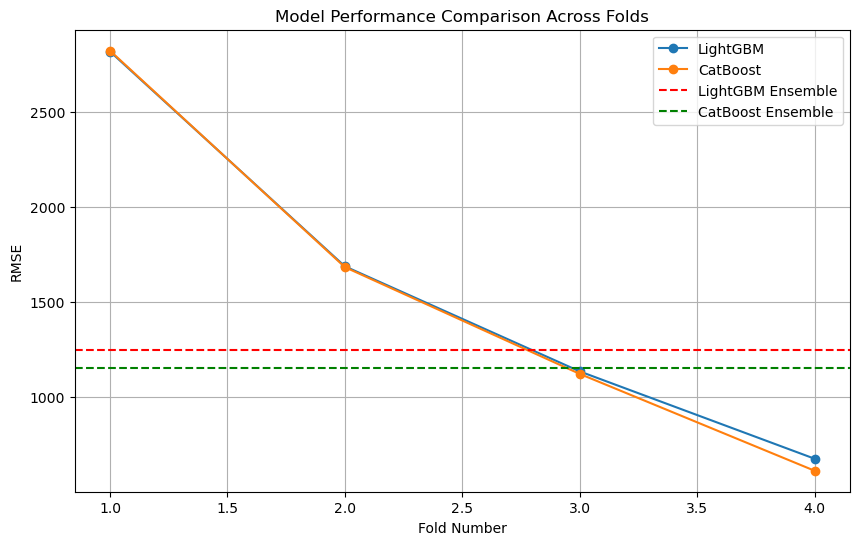

In [34]:
lgb_rmses = [mean_squared_error(df_test[target], test_predictions[:, i], squared=False) 
             for i in range(len(enumeratelist))]
cat_rmses = [mean_squared_error(df_test[target], test_predictions_catboost[:, i], squared=False) 
            for i in range(len(enumeratelist))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(enumeratelist)+1), lgb_rmses, 'o-', label='LightGBM')
plt.plot(range(1, len(enumeratelist)+1), cat_rmses, 'o-', label='CatBoost')
plt.axhline(test_rmse, color='r', linestyle='--', label='LightGBM Ensemble')
plt.axhline(test_rmse_catboost, color='g', linestyle='--', label='CatBoost Ensemble')
plt.xlabel('Fold Number')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison Across Folds')
plt.legend()
plt.grid()
plt.show()